In [1]:
import torch
torch.__version__

/home/pradeep/Documents/PyTorch_tutorial/pytorch-env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.10.1+cu102'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# setting up seed for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True  # use deterministic algo wherever possible
torch.backends.cudnn.benchmark = False  # in benchmark mode input size stays constant and 
# cuda can optimize some parts for optimizationS

/home/pradeep/Documents/PyTorch_tutorial/pytorch-env/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
# setting up device
device = "cuda" if torch.cuda.is_available() else "cpu"

### Activation Function

In [5]:
import torch.nn as nn
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

In [6]:
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))
    
class TanH(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp)/(x_exp + neg_x_exp)
    
class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0).float()
    
class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x>0, x, self.config["alpha"] * x)
    
class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x>0, x, torch.exp(x)-1)
    
class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)


In [7]:
# activation function mapping

act_map = {
    "sigmoid": Sigmoid,
    "tanh": TanH,
    "relu": ReLU,
    "leaky_relu": LeakyReLU,
    "elu": ELU,
    "swish": Swish,
}

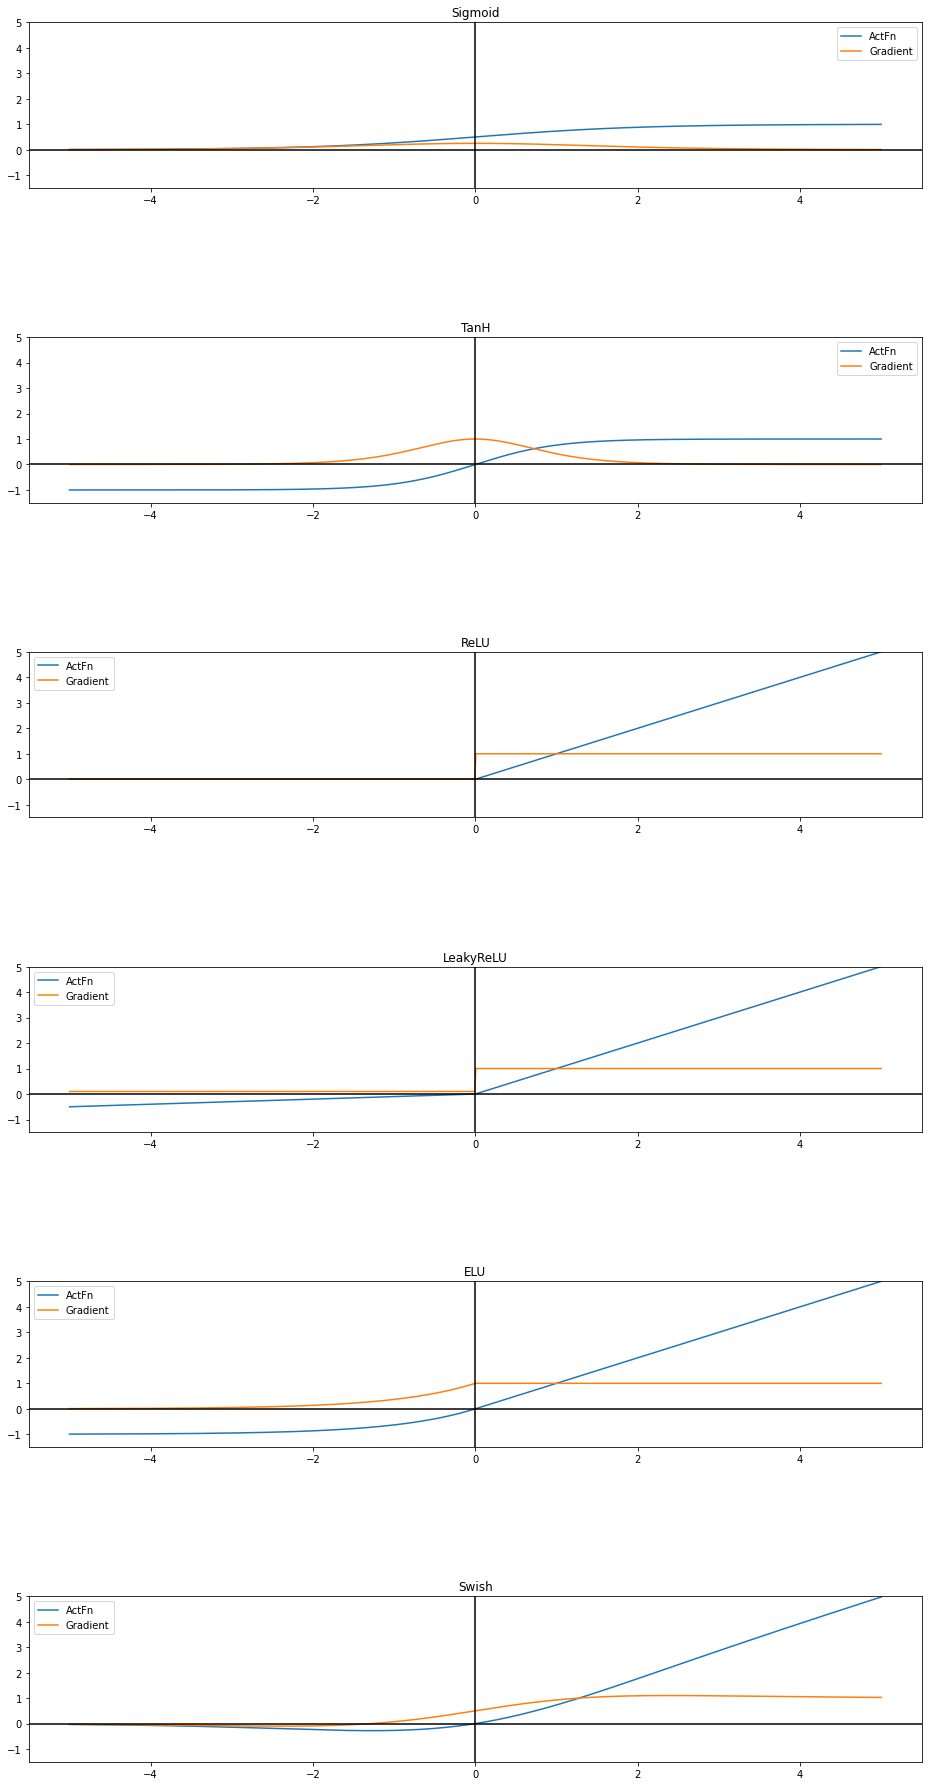

In [8]:
def get_grads(act_fc, x):

    x = x.clone().requires_grad_()
    out = act_fc(x)
    out.sum().backward()
    return x.grad

def visualize_activation(act_fn, ax , x):

    y = act_fn(x)
    y_grad = get_grads(act_fn, x)
    x , y, y_grad = x.cpu().numpy(), y.cpu().numpy(), y_grad.cpu().numpy()

    ax.plot(x, y, label="ActFn")
    ax.plot(x, y_grad, label="Gradient")
    ax.set_title(act_fn.name)
    ax.set_ylim(-1.5, x.max())
    ax.axvline(0, color="black")
    ax.axhline(0, color="black")
    ax.legend()


act_fns = [act_fn() for act_fn in act_map.values()]

x = torch.linspace(-5, 5, 1000)

fig, ax = plt.subplots(6, 1, figsize=(16, 32))

for i, act_fn in enumerate(act_fns):
    visualize_activation(act_fn, ax[i], x)
fig.subplots_adjust(hspace=0.9)
plt.show()

In [9]:
import os

In [10]:
DATASET_PATH = "data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/tutorial3"

In [11]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"
# Files to download
pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

### Define Network

In [12]:
import torch
import torch.nn as nn

class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_size=[512, 256, 256, 128]):
        super().__init__()

        layers = []
        layer_sizes = [input_size] + hidden_size
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]), act_fn]

        layers += [nn.Linear(layer_sizes[-1], num_classes)]

        self.layers = nn.Sequential(*layers)

        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_size": hidden_size}


    def forward(self, x): 
        x = x.view(x.size(0), -1)  # performing ravel operation here
        out = self.layers(x)
        return out





In [13]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

In [14]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": TanH,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

In [15]:
import json
device = device
def load_model(model_path, model_name, net=None):
    """
    Loads a saved model from disk.

    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        net - (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net

In [16]:
def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.

    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

### Get DataSet

In [17]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [19]:
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)


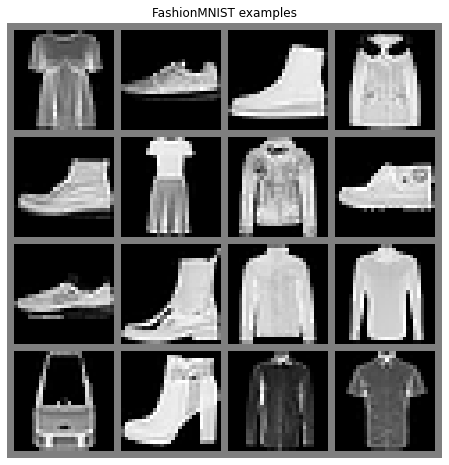

In [20]:
import matplotlib.pyplot as plt
exp_images = [train_set[i][0] for i in range(16)]
img_grid = torchvision.utils.make_grid(torch.stack(exp_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()

### Visualize Gradient

In [21]:
import torch.nn.functional as F
import seaborn as sns


In [22]:
def visualize_gradient(net):
    net.eval()

    small_loader = data.DataLoader(train_set, shuffle=False, batch_size=256)
    img, labels = next(iter(small_loader))
    img, labels = img.to(device), labels.to(device)

    net.zero_grad()
    pred = net(img)
    loss = F.cross_entropy(pred, labels)
    loss.backward()

    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}

    columns = len(grads)

    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_ylabel("Grad Magnitude")
        fig_index += 1

    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()

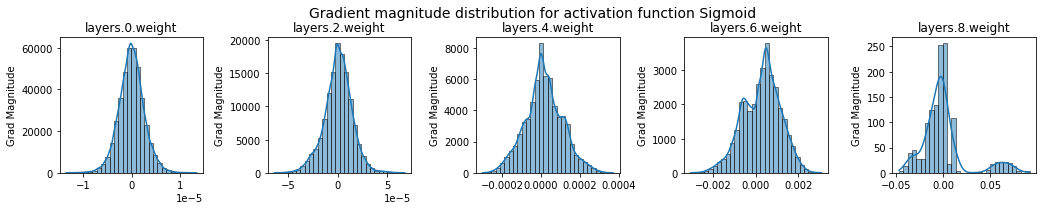

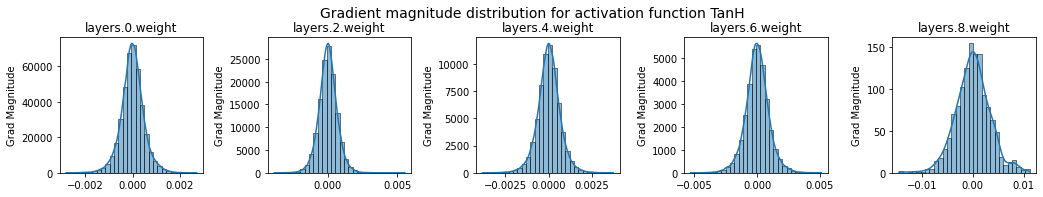

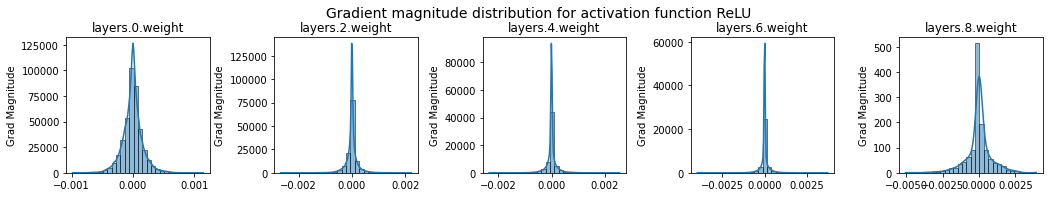

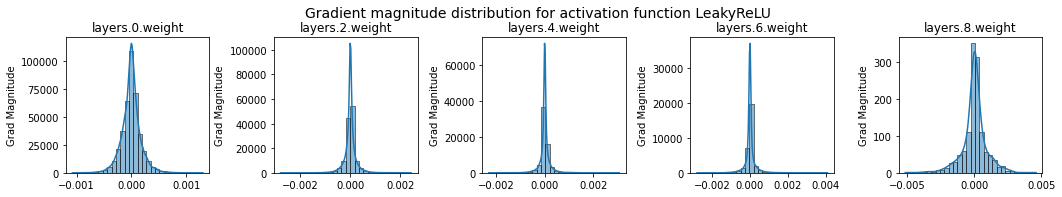

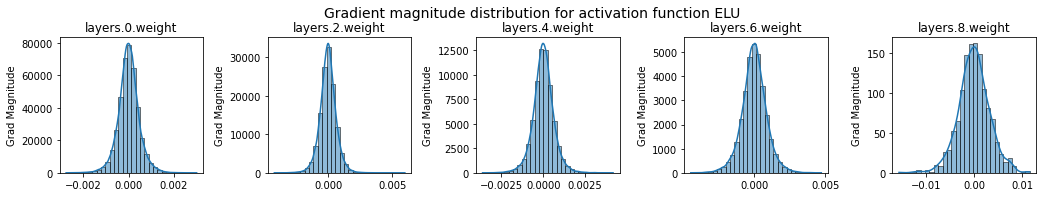

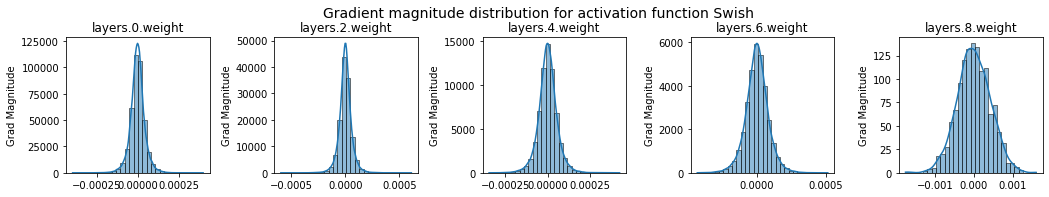

In [23]:
for i, act_fn_name in enumerate(act_fn_by_name):
    torch.manual_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_acatfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradient(net_acatfn)

1. For sigmoid we can see that as gradient move from last layer to first layer it becomes very small, hence it is not used in deep networks
2. TanH is definitely an improvement on sigmoid in this size of network
3. ReLU and LeakyReLU produces very sharp curve around 0 as we squash all the values less than 0 to 0. This sharp peak is not an issue as long as this is consistent across differnt layers of the network
4. ELU and Swish produces smooth curves as the function is smooth.

In [24]:
from tqdm import tqdm

def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device) # To GPU
                optimizer.zero_grad() # Zero-grad can be placed anywhere before "loss.backward()"
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

In [25]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    torch.manual_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...
============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation...
Model file already exists. Skipping training...
============= Test accuracy: 87.59% ==============

Training BaseNetwork with relu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.62% ==============

Training BaseNetwork with leakyrelu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.92% ==============

Training BaseNetwork with elu activation...
Model file already exists. Skipping training...
============= Test accuracy: 87.27% ==============

Training BaseNetwork with swish activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.73% ==============



Not surprisingly, the model using the sigmoid activation function shows to fail and does not improve upon random performance (10 classes => 1/10 for random chance). All the other activation functions gain similar performance. 
### Visualize Layer Activations

In [26]:
import math
def visualize_activations(net, color="C0"):
    net.eval()

    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, label = next(iter(small_loader))
    activations = {}
    with torch.no_grad():
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)  # ravel operation

        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()

    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    

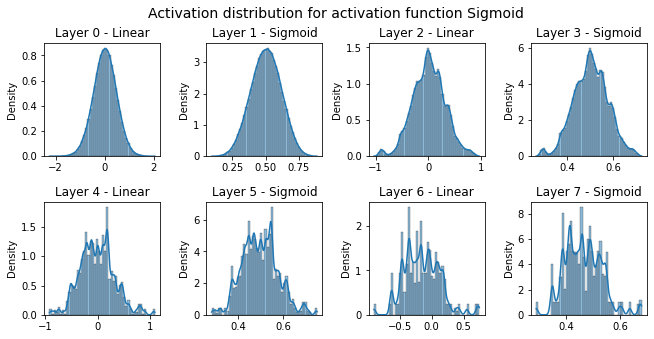

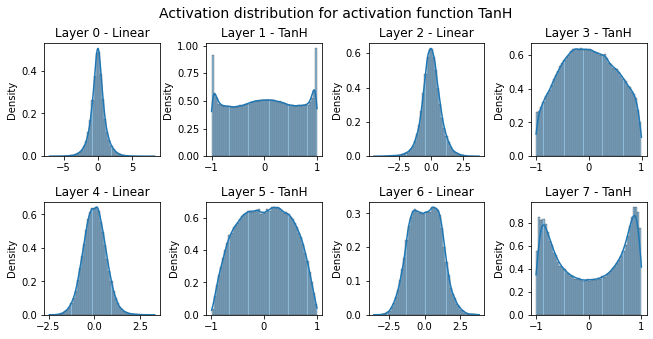

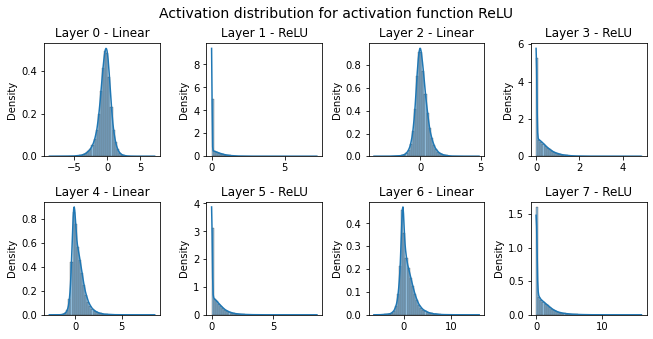

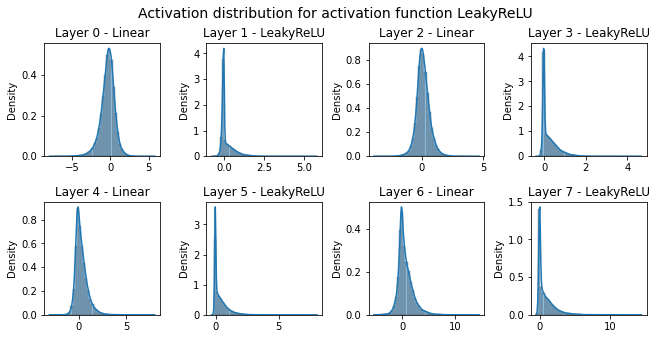

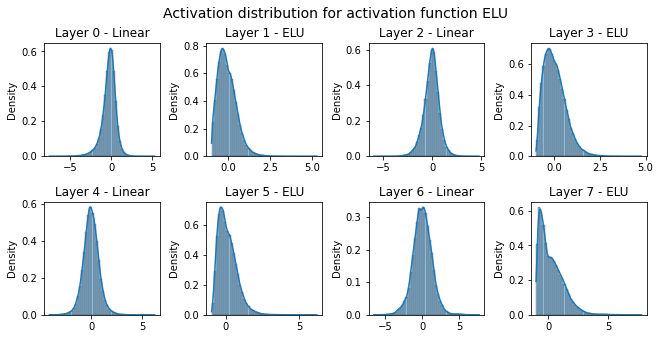

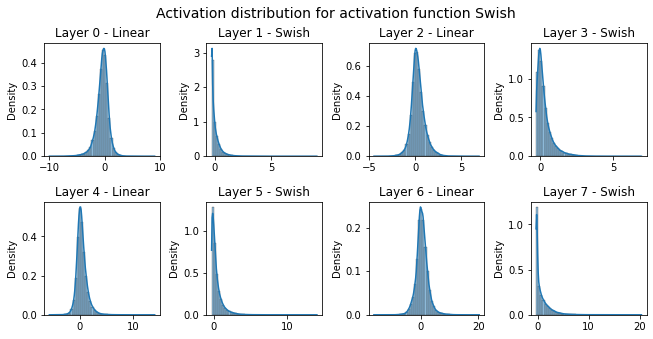

In [27]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn)

### Finding Dead Neuron
For a neuron to be considered dead, the output of the neuron has to negative for all the input images.

In [34]:
def measure_number_dead_neurons(net):

    neuron_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool) for layer in net.layers[:-1] if isinstance(layer, nn.Linear)
    ]

    net.eval()

    for imgs, labels in tqdm(train_loader, leave=False):
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        layer_index = 0
        for layer in net.layers[:-1]:
            imgs = layer(imgs)
            if isinstance(layer, ActivationFunction):
                neuron_dead[layer_index] = torch.logical_and(neuron_dead[layer_index], (imgs==0).all(dim=0))
                layer_index += 1

    number_neurons_dead = [t.sum().item() for t in neuron_dead]

    print("Number of dead neurons: ", number_neurons_dead)
    print("In percentage: ", ", ".join(f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neuron_dead, number_neurons_dead)))

In [36]:
torch.manual_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

Number of dead neurons:  [0, 0, 3, 10]
In percentage:  0.00%, 0.00%, 1.17%, 7.81%


In [37]:
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

Number of dead neurons:  [0, 0, 0, 3]
In percentage:  0.00%, 0.00%, 0.00%, 2.34%


In [39]:
net_relu = BaseNetwork(act_fn=ReLU(), hidden_size=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128]).to(device)
measure_number_dead_neurons(net_relu)

Number of dead neurons:  [0, 0, 7, 30, 85, 56, 67, 63, 66, 61]
In percentage:  0.00%, 0.00%, 2.73%, 11.72%, 33.20%, 43.75%, 52.34%, 49.22%, 51.56%, 47.66%


The number of dead neurons is significantly higher than before which harms the gradient flow especially in the first iterations. For instance, more than 56% of the neurons in the pre-last layer are dead which creates a considerable bottleneck. Hence, it is advisible to use other nonlinearities like Swish for very deep networks.